### Assignment 06: Model Evaluation

using the attached file, you are going to get experience using grid search and cross-validation.

Directions:

Create a new repo in your GitHub for DATA602. It should contain:
- a brief readme
- data folder with the attached data
- your notebook

Using the attached data, create a Jupyter Notebook
- Inspect the data and create a pipeline to perform any feature processing
- Prior to building the feature pipeline, be sure to split the data into training/test sets
- Create a logistic regression model pipeline that uses the above pipeline
- Pick a metric you are going to use to select the model and justify your choice.
- Use the above combined pipeline to run a Logistic Regression model with grid search cross-validation using 10 folds. Search 5 different regularization strengths and 2 solvers. What is the best model? How does it perform on the test set?


_The variable you should be predicting in the 'Class' column._


Submit a link to your Github repo.

In [1]:
# --- Importing the Data and Modules --- #
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

df = pd.read_csv("data/pima_indian_data.csv")
df.head(10)

,Number of times pregnant,Plasma glucose,Diastolic blood pressure,Triceps skinfold thickness,serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


_Table 1: Shown here is the raw imported data from the provided dataset. A detailed description of the data can be fouind in the ReadMe_Assignment_06.md file of this directory. The "Class" columnn is the objective for a binary classification model._

In [2]:
print(df.isna().sum().sum())
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Number  of times pregnant   768 non-null    int64  
 1   Plasma glucose              768 non-null    int64  
 2   Diastolic blood pressure    768 non-null    int64  
 3   Triceps skinfold thickness  768 non-null    int64  
 4   serum insulin               768 non-null    int64  
 5   Body mass index             768 non-null    float64
 6   Diabetes pedigree function  768 non-null    float64
 7   Age                         768 non-null    int64  
 8   Class                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


_Table 2: Shown here is the data types (Dtype), number of values (non-null count) for each column of Table 1. Notice each column is numeric 64-bit integer of float with no null values._

First I have imported some necessary standard packages/modules (numpy, matplotlib, and pandas). These will assist in the exploritory data analysis (EDA) and completion of a working regression model for the dataset.

In [3]:
x = df.drop(columns=["Class"])
y = df.Class
x_names = df.columns

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of times pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Plasma glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Diastolic blood pressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
Triceps skinfold thickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
serum insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
Body mass index,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Diabetes pedigree function,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


_Table 3: Shown here is a brief statistical description of the dataset showing the number of values (count), the mean value, standard deviation (std), minimum value (min), and percentieles of 25%, 50%, and 75%, as well as the maximum (max) value for each column._

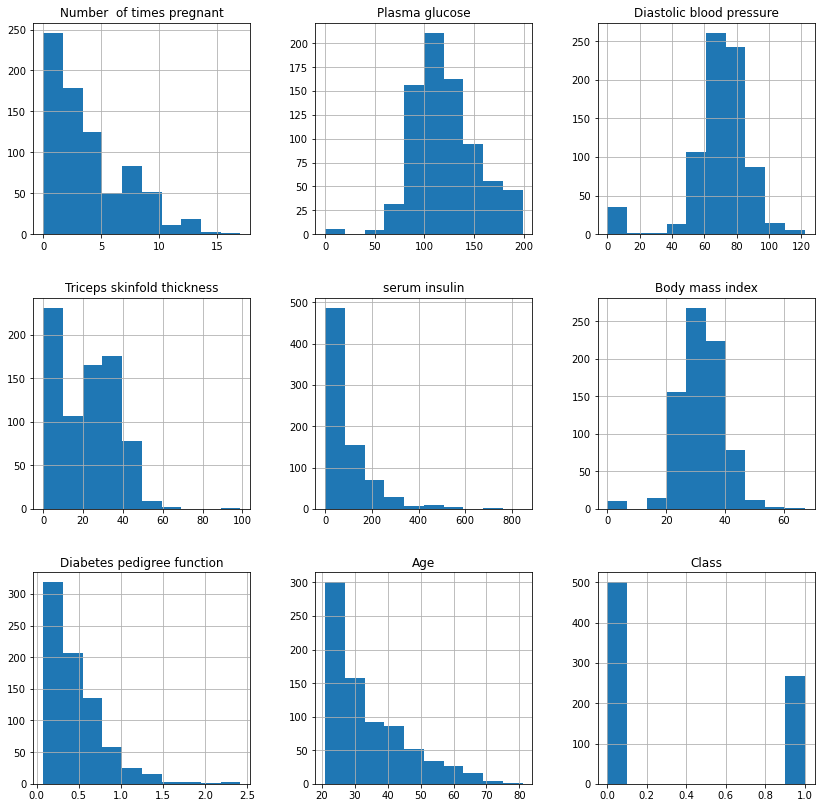

In [4]:
df.hist(figsize=(14,14))
plt.show()

_Figure 1: shown here is a histogram of each column in the dataset._

There do not seem to be any obvious issues with data quality. Also note that the values are all on different scates, I will need to standardize the dataset.  

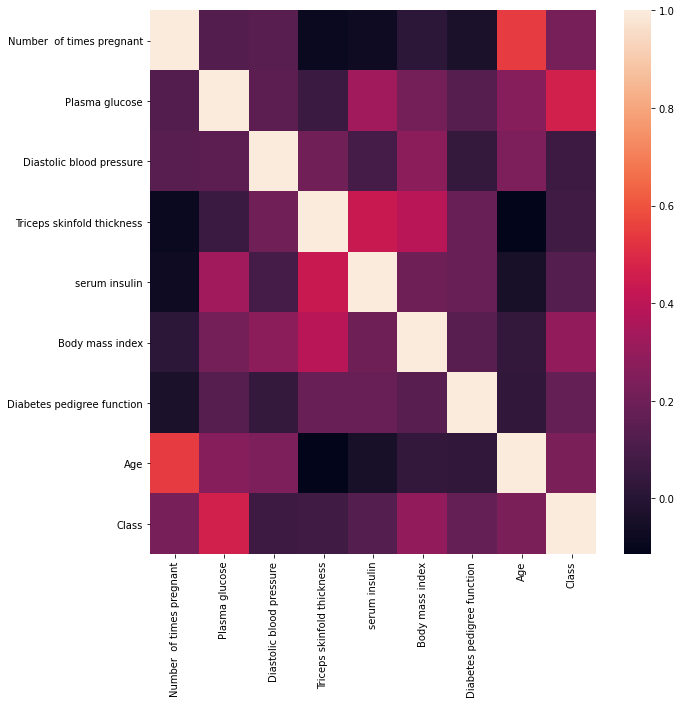

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())
plt.show()

_Figure 2: Shown here is the correlation heatmap for the dataset._

There may be some multicolinearity in the dataset, therefore a Principal Component Analysis (PCA) will be encorporated in the pipeline.

### Pipeline Gameplan
- Establish the Training and Test sets from the data
- Create the data processing pipeline
    - standardize the data features
    - extract a 3 component PCA
- Perform the Logistic Regression
    - two solvers: 'liblinear' (penalty = l2) and 'lbfgs' (penalty = none) 
- Evaluate the model "accuracy"
    - F1-Score
    - ROC AUC
    -Refit with ROC AUC

In [6]:
# --- Splitting the Data --- #
from sklearn.model_selection import train_test_split as tts

def create_splits(x, y): 
    return tts(x,y,test_size=0.20, random_state=1)

x_train, x_test, y_train, y_test = create_splits(x,y)

print(f"Training Sample: {x_train.shape[0]:,}")
print(f"Test Sample: {x_test.shape[0]:,}")

Training Sample: 614
Test Sample: 154


The above code splits the dataset into a training-set and test-set which 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

lg_pipe = modeling_pipeline = Pipeline([
        ('scaler', StandardScaler()),
         ('pca', PCA(n_components=3)),
         ('logreg', LogisticRegression(penalty='l2', solver='liblinear', random_state=1))
        ]
    )
        
param_grid = [{'logreg__C': [1, 10, 100, 1000, 10000], 'pca__n_components': [1,2,3,4,5,6,7,8]}]

gcv_results = GridSearchCV(estimator=lg_pipe, param_grid=param_grid, scoring=['f1_macro', 'roc_auc'], refit="roc_auc", cv=10)
gcv_results = gcv_results.fit(x_train, y_train)

In [8]:
pd.DataFrame.from_dict(gcv_results.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
mean_fit_time,0.007445,0.004,0.0041,0.004151,0.0052,0.0043,0.004999,0.0035,0.0039,0.003951,...,0.004,0.004,0.0044,0.0044,0.004,0.004,0.0042,0.0041,0.0037,0.0039
std_fit_time,0.009314,0.000001,0.0003,0.000553,0.001661,0.000458,0.003347,0.0005,0.000538,0.000351,...,0.000632,0.000447,0.00049,0.00049,0.000002,0.000447,0.0006,0.000538,0.000458,0.000539
mean_score_time,0.00359,0.0048,0.0035,0.003501,0.0039,0.0036,0.003701,0.0038,0.0035,0.0038,...,0.0038,0.0036,0.0037,0.0037,0.003301,0.0033,0.0037,0.0035,0.003401,0.0037
std_score_time,0.000658,0.003429,0.0005,0.0005,0.000539,0.00049,0.000641,0.000602,0.0005,0.0006,...,0.000748,0.000489,0.000458,0.00064,0.000458,0.000458,0.000458,0.0005,0.000665,0.00064
param_logreg__C,1,1,1,1,1,1,1,1,10,10,...,1000,1000,10000,10000,10000,10000,10000,10000,10000,10000
param_pca__n_components,1,2,3,4,5,6,7,8,1,2,...,7,8,1,2,3,4,5,6,7,8
params,"{'logreg__C': 1, 'pca__n_components': 1}","{'logreg__C': 1, 'pca__n_components': 2}","{'logreg__C': 1, 'pca__n_components': 3}","{'logreg__C': 1, 'pca__n_components': 4}","{'logreg__C': 1, 'pca__n_components': 5}","{'logreg__C': 1, 'pca__n_components': 6}","{'logreg__C': 1, 'pca__n_components': 7}","{'logreg__C': 1, 'pca__n_components': 8}","{'logreg__C': 10, 'pca__n_components': 1}","{'logreg__C': 10, 'pca__n_components': 2}",...,"{'logreg__C': 1000, 'pca__n_components': 7}","{'logreg__C': 1000, 'pca__n_components': 8}","{'logreg__C': 10000, 'pca__n_components': 1}","{'logreg__C': 10000, 'pca__n_components': 2}","{'logreg__C': 10000, 'pca__n_components': 3}","{'logreg__C': 10000, 'pca__n_components': 4}","{'logreg__C': 10000, 'pca__n_components': 5}","{'logreg__C': 10000, 'pca__n_components': 6}","{'logreg__C': 10000, 'pca__n_components': 7}","{'logreg__C': 10000, 'pca__n_components': 8}"
split0_test_f1_macro,0.69031,0.732989,0.741667,0.76315,0.799589,0.819977,0.819977,0.819977,0.69031,0.732989,...,0.819977,0.819977,0.69031,0.732989,0.741667,0.76315,0.799589,0.819977,0.819977,0.819977
split1_test_f1_macro,0.594771,0.644646,0.595527,0.608586,0.608586,0.635294,0.62183,0.635294,0.594771,0.644646,...,0.62183,0.635294,0.594771,0.644646,0.595527,0.608586,0.608586,0.635294,0.62183,0.635294
split2_test_f1_macro,0.634048,0.60724,0.594048,0.582619,0.582619,0.682955,0.639954,0.667857,0.634048,0.60724,...,0.639954,0.667857,0.634048,0.60724,0.594048,0.582619,0.582619,0.682955,0.639954,0.667857


_Table 4: Shown here are the return values for the 10-fold grid search crossvalidation wiht f1-scoring and of the dataset using a **liblinear (l2)** solver._

In [9]:
print(f"The best score was of {gcv_results.best_score_:.3} from estimators {gcv_results.best_estimator_}")

The best score was of 0.826 from estimators Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('logreg',
                 LogisticRegression(C=10, random_state=1, solver='liblinear'))])


#### Now with 'liblinear' (l1) solver

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

lg_pipe = modeling_pipeline = Pipeline([
        ('scaler', StandardScaler()),
         ('pca', PCA(n_components=3)),
         ('logreg', LogisticRegression(penalty="l2", solver='lbfgs', random_state=1))
        ]
    )
        
param_grid = [
  {'logreg__C': [1, 10, 100, 1000, 10000], 'pca__n_components': [1,2,3, 4, 5, 6, 7, 8]}
 ]

gcv_results = GridSearchCV(estimator=lg_pipe, param_grid=param_grid, scoring=['f1_macro', 'roc_auc'], refit="roc_auc", cv=10)
gcv_results = gcv_results.fit(x_train, y_train)

In [11]:
pd.DataFrame.from_dict(gcv_results.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
mean_fit_time,0.006001,0.0067,0.0059,0.0058,0.0056,0.005851,0.0056,0.0055,0.005,0.0052,...,0.0057,0.0057,0.0053,0.0059,0.0059,0.006151,0.0059,0.006399,0.0056,0.0053
std_fit_time,0.001414,0.003132,0.00083,0.0006,0.000663,0.000451,0.00049,0.000806,0.000447,0.0006,...,0.00064,0.000458,0.000458,0.000538,0.000943,0.00055,0.000539,0.000489,0.000664,0.000458
mean_score_time,0.004199,0.0038,0.0035,0.0038,0.0036,0.0035,0.003604,0.0034,0.0035,0.0038,...,0.0038,0.0041,0.003951,0.0038,0.0036,0.0037,0.0039,0.003901,0.0036,0.003851
std_score_time,0.000602,0.000872,0.0005,0.0006,0.000663,0.0005,0.000486,0.00049,0.0005,0.0004,...,0.0004,0.0003,0.000723,0.000749,0.00049,0.000458,0.000538,0.000538,0.00049,0.000319
param_logreg__C,1,1,1,1,1,1,1,1,10,10,...,1000,1000,10000,10000,10000,10000,10000,10000,10000,10000
param_pca__n_components,1,2,3,4,5,6,7,8,1,2,...,7,8,1,2,3,4,5,6,7,8
params,"{'logreg__C': 1, 'pca__n_components': 1}","{'logreg__C': 1, 'pca__n_components': 2}","{'logreg__C': 1, 'pca__n_components': 3}","{'logreg__C': 1, 'pca__n_components': 4}","{'logreg__C': 1, 'pca__n_components': 5}","{'logreg__C': 1, 'pca__n_components': 6}","{'logreg__C': 1, 'pca__n_components': 7}","{'logreg__C': 1, 'pca__n_components': 8}","{'logreg__C': 10, 'pca__n_components': 1}","{'logreg__C': 10, 'pca__n_components': 2}",...,"{'logreg__C': 1000, 'pca__n_components': 7}","{'logreg__C': 1000, 'pca__n_components': 8}","{'logreg__C': 10000, 'pca__n_components': 1}","{'logreg__C': 10000, 'pca__n_components': 2}","{'logreg__C': 10000, 'pca__n_components': 3}","{'logreg__C': 10000, 'pca__n_components': 4}","{'logreg__C': 10000, 'pca__n_components': 5}","{'logreg__C': 10000, 'pca__n_components': 6}","{'logreg__C': 10000, 'pca__n_components': 7}","{'logreg__C': 10000, 'pca__n_components': 8}"
split0_test_f1_macro,0.69031,0.732989,0.741667,0.76315,0.799589,0.819977,0.819977,0.819977,0.69031,0.732989,...,0.819977,0.819977,0.69031,0.732989,0.741667,0.76315,0.799589,0.819977,0.819977,0.819977
split1_test_f1_macro,0.594771,0.644646,0.595527,0.608586,0.608586,0.607726,0.62183,0.635294,0.594771,0.644646,...,0.62183,0.635294,0.594771,0.644646,0.595527,0.608586,0.608586,0.635294,0.62183,0.635294
split2_test_f1_macro,0.634048,0.60724,0.594048,0.582619,0.582619,0.682955,0.639954,0.667857,0.634048,0.60724,...,0.639954,0.667857,0.634048,0.60724,0.594048,0.582619,0.582619,0.682955,0.639954,0.667857


_Table 4: Shown here are the return values for the 10-fold grid search crossvalidation wiht f1-scoring and of the dataset using a **nliblinear (l1)** estimator._

In [55]:
res_lbfgs = pd.DataFrame.from_dict(gcv_results.cv_results_)
res_lbfgs = res_lbfgs.drop(columns="params")

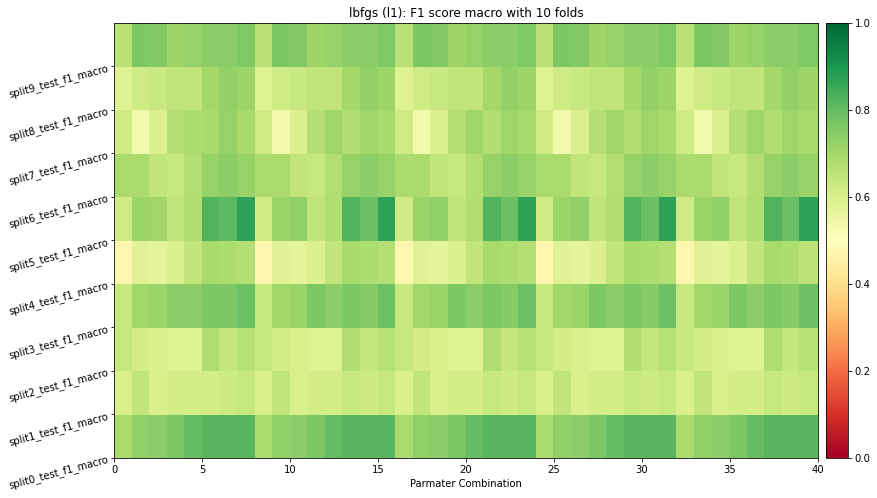

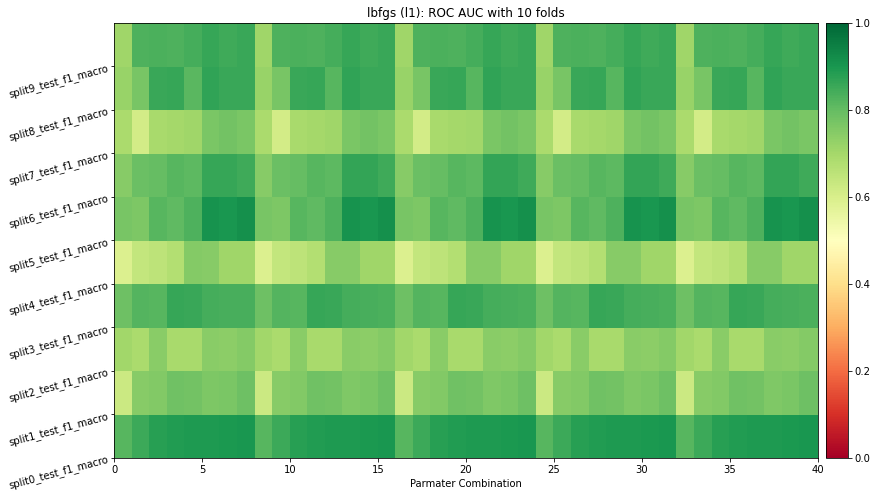

In [88]:
f1_cols = [f"split{i}_test_f1_macro" for i in range(0,10)]
res_lbfgs_np = res_lbfgs[f1_cols].to_numpy(copy=True)

fig, ax = plt.subplots(figsize=(15,8))
im = ax.pcolormesh(res_lbfgs_np.T, vmin=0, vmax=1, cmap="RdYlGn")
fig.colorbar(im, ax=ax, pad=0.01)

ax.set_yticks(np.arange(len(f1_cols)))
ax.set_yticklabels(f1_cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=15, ha="right",
         rotation_mode="anchor")

plt.title("lbfgs (l1): F1 score macro with 10 folds")
plt.xlabel("Parmater Combination")
plt.show()


roc_auc_score = [f"split{i}_test_roc_auc" for i in range(0,10)]
res_lbfgs_np = res_lbfgs[roc_auc_score].to_numpy(copy=True)

fig, ax = plt.subplots(figsize=(15,8))
im = ax.pcolormesh(res_lbfgs_np.T, vmin=0, vmax=1, cmap="RdYlGn")
fig.colorbar(im, ax=ax, pad=0.01)

ax.set_yticks(np.arange(len(f1_cols)))
ax.set_yticklabels(f1_cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=15, ha="right",
         rotation_mode="anchor")

plt.title("lbfgs (l1): ROC AUC with 10 folds")
plt.xlabel("Parmater Combination")
plt.show()

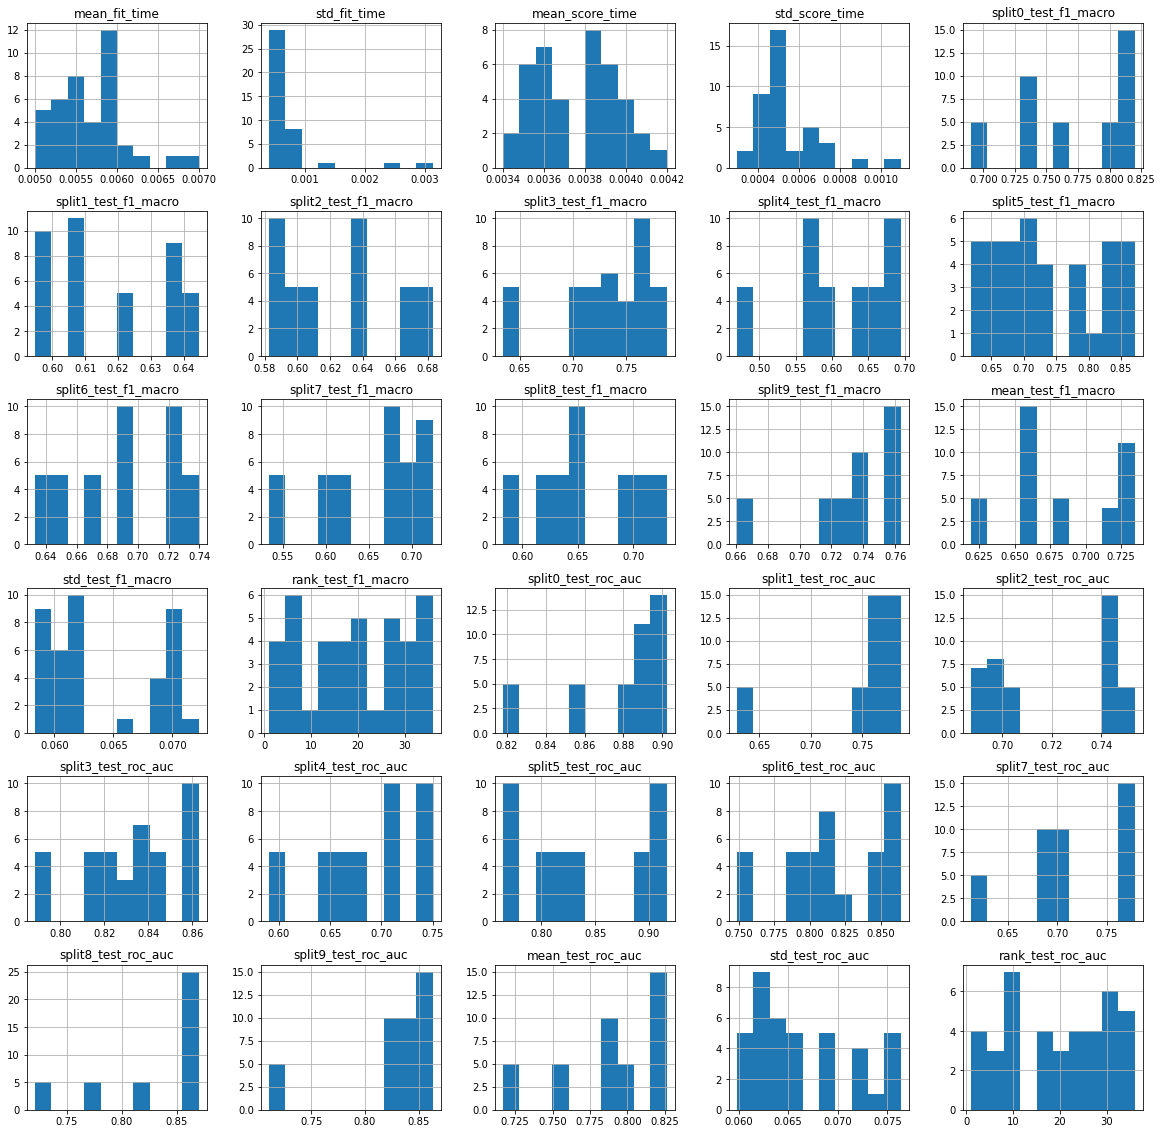

In [54]:
 



res_lbfgs.hist(figsize=(20,20))
plt.show()

In [13]:
print(f"The best score was of {gcv_results.best_score_:.3} from estimators {gcv_results.best_estimator_}")

The best score was of 0.826 from estimators Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('logreg', LogisticRegression(C=10, random_state=1))])


The overall scores, best PCA components, and regularizatio nstrength do not differ. So To choose the 'best' model would be the one with the fewest entires in code length and thus the second gcv wtih _Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=6)), ('logreg', LogisticRegression(C=10, random_state=1))])_ would suffice.